# Модель нейронной сети с векторизацией Bert Sentence
### Импорт всех необходимых модулей

In [ ]:
import os
import pandas as pd
import nltk
from tensorflow.keras import Input, regularizers, Model
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Concatenate, Dropout, LSTM, GRU
from tensorflow.keras.layers import Input, Embedding, GlobalAveragePooling1D, Dense, Dropout, Concatenate, Reshape
from tensorflow.keras.optimizers import Adam, AdamW, RMSprop, SGD, Adadelta, Adagrad, Nadam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix

### Работа с предобработкой датасета

In [ ]:
from google.colab import files

# Загружаем файл
uploaded = files.upload()

Saving bert_sentence.csv to bert_sentence.csv


In [ ]:
df = pd.read_csv("bert_sentence.csv")
df.head()

,Unnamed: 0.1,Unnamed: 0,User review,Review date,Star review,Text length,Has media,Has answer,Written by bot
0,0,0,"[0.05245498567819595, 0.5145626664161682, -0.0...",2024-10-09,5,54,0,0,0
1,1,1,"[-0.1686820238828659, 0.6197441220283508, -0.1...",2024-10-09,5,195,0,0,0
2,2,2,"[-0.40249526500701904, 0.5722190737724304, -0....",2024-10-09,5,17,0,0,0
3,3,3,"[-0.39001303911209106, 0.5532811880111694, -0....",2024-10-09,5,33,0,0,0
4,4,4,"[-0.36473825573921204, 0.5338039994239807, -0....",2024-10-09,5,15,0,0,0


In [ ]:
import ast
df["User review"] = df["User review"].apply(ast.literal_eval)

In [ ]:
df.head()

,Unnamed: 0.1,Unnamed: 0,User review,Review date,Star review,Text length,Has media,Has answer,Written by bot
0,0,0,"[0.05245498567819595, 0.5145626664161682, -0.0...",2024-10-09,5,54,0,0,0
1,1,1,"[-0.1686820238828659, 0.6197441220283508, -0.1...",2024-10-09,5,195,0,0,0
2,2,2,"[-0.40249526500701904, 0.5722190737724304, -0....",2024-10-09,5,17,0,0,0
3,3,3,"[-0.39001303911209106, 0.5532811880111694, -0....",2024-10-09,5,33,0,0,0
4,4,4,"[-0.36473825573921204, 0.5338039994239807, -0....",2024-10-09,5,15,0,0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2416 entries, 0 to 2415
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0.1    2416 non-null   int64 
 1   Unnamed: 0      2416 non-null   int64 
 2   User review     2416 non-null   object
 3   Review date     2416 non-null   object
 4   Star review     2416 non-null   int64 
 5   Text length     2416 non-null   int64 
 6   Has media       2416 non-null   object
 7   Has answer      2416 non-null   int64 
 8   Written by bot  2416 non-null   int64 
dtypes: int64(6), object(3)
memory usage: 170.0+ KB


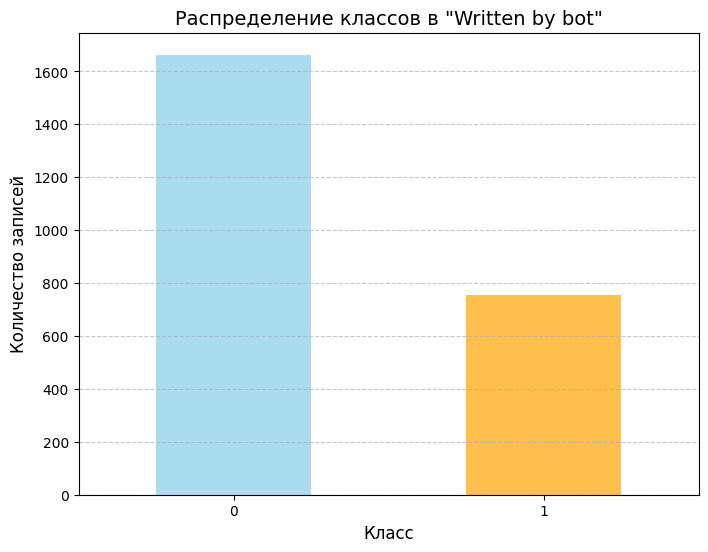

In [ ]:
df_balance = df.copy()
class_counts = df['Written by bot'].value_counts()
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color=['skyblue', 'orange'], alpha=0.7)
plt.title('Распределение классов в "Written by bot"', fontsize=14)
plt.xlabel('Класс', fontsize=12)
plt.ylabel('Количество записей', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
df = df.drop(columns=["Review date"])
df.head()

,Unnamed: 0.1,Unnamed: 0,User review,Star review,Text length,Has media,Has answer,Written by bot
0,0,0,"[0.05245498567819595, 0.5145626664161682, -0.0...",5,54,0,0,0
1,1,1,"[-0.1686820238828659, 0.6197441220283508, -0.1...",5,195,0,0,0
2,2,2,"[-0.40249526500701904, 0.5722190737724304, -0....",5,17,0,0,0
3,3,3,"[-0.39001303911209106, 0.5532811880111694, -0....",5,33,0,0,0
4,4,4,"[-0.36473825573921204, 0.5338039994239807, -0....",5,15,0,0,0


In [ ]:
df.columns = df.columns.str.strip()
df = df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'], errors='ignore')


In [ ]:
df.head()

,User review,Star review,Text length,Has media,Has answer,Written by bot
0,"[0.05245498567819595, 0.5145626664161682, -0.0...",5,54,0,0,0
1,"[-0.1686820238828659, 0.6197441220283508, -0.1...",5,195,0,0,0
2,"[-0.40249526500701904, 0.5722190737724304, -0....",5,17,0,0,0
3,"[-0.39001303911209106, 0.5532811880111694, -0....",5,33,0,0,0
4,"[-0.36473825573921204, 0.5338039994239807, -0....",5,15,0,0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2416 entries, 0 to 2415
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   User review     2416 non-null   object
 1   Star review     2416 non-null   int64 
 2   Text length     2416 non-null   int64 
 3   Has media       2416 non-null   object
 4   Has answer      2416 non-null   int64 
 5   Written by bot  2416 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 113.4+ KB


In [ ]:
df['Has media'] = df['Has media'].replace({'True': '1', 'False': '0'})
df['Has media'].value_counts()

,count
Has media,
0,1699
1,717


In [ ]:
y = df['Written by bot']
X = df.drop(columns=['Written by bot']).values

In [ ]:
nan_counts = df.isna().sum()
df = df.fillna(0)
nan_counts = df.isna().sum()
print(nan_counts)

User review       0
Star review       0
Text length       0
Has media         0
Has answer        0
Written by bot    0
dtype: int64


In [ ]:
y, X = df['Written by bot'], df.drop(columns=['Written by bot'])

Исходное распределение классов: Counter({0: 1663, 1: 753})


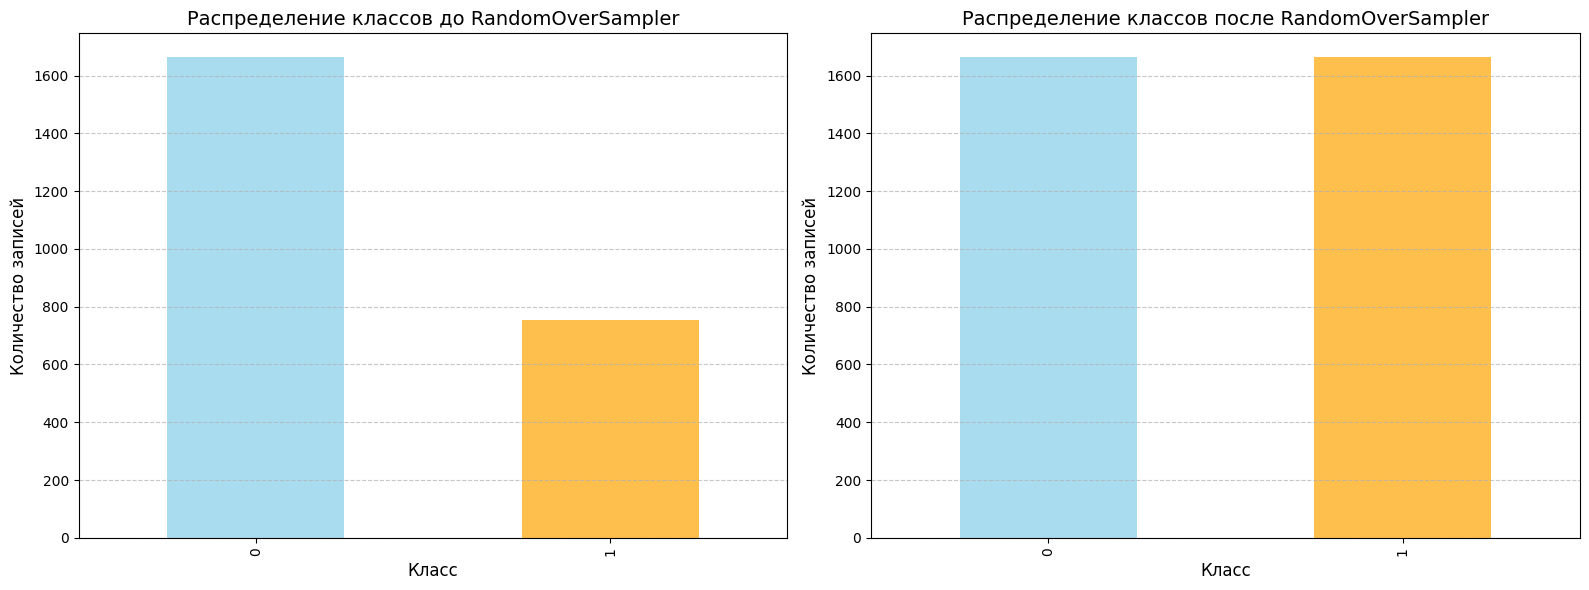

In [ ]:
print("Исходное распределение классов:", Counter(y))

ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X, y)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

class_counts_before = y.value_counts()
class_counts_before.plot(kind='bar', color=['skyblue', 'orange'], alpha=0.7, ax=axes[0])
axes[0].set_title('Распределение классов до RandomOverSampler', fontsize=14)
axes[0].set_xlabel('Класс', fontsize=12)
axes[0].set_ylabel('Количество записей', fontsize=12)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

class_counts_after = pd.Series(y_ros).value_counts()
class_counts_after.plot(kind='bar', color=['skyblue', 'orange'], alpha=0.7, ax=axes[1])
axes[1].set_title('Распределение классов после RandomOverSampler', fontsize=14)
axes[1].set_xlabel('Класс', fontsize=12)
axes[1].set_ylabel('Количество записей', fontsize=12)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2416 entries, 0 to 2415
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   User review     2416 non-null   object
 1   Star review     2416 non-null   int64 
 2   Text length     2416 non-null   int64 
 3   Has media       2416 non-null   object
 4   Has answer      2416 non-null   int64 
 5   Written by bot  2416 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 113.4+ KB


In [ ]:
import tensorflow as tf
X_ros_df = pd.DataFrame(X_ros, columns=df.drop(columns=['Written by bot']).columns)
X_ros_df['User review'] = X_ros_df['User review']
X_ros_text = X_ros_df['User review']
X_ros_text = np.array(X_ros_text.tolist(), dtype=np.float32)
X_ros_text_padded = tf.keras.preprocessing.sequence.pad_sequences(
    X_ros_text, maxlen=1000, padding='post', truncating='post'
)
X_ros_numeric = X_ros_df.drop(columns=['User review'])
X_ros_numeric = np.array(X_ros_numeric, dtype=np.float32)

In [ ]:
X_train_text, X_test_text, X_train_num, X_test_num, y_train, y_test = train_test_split(
    X_ros_text, X_ros_numeric, y_ros, test_size=0.2, random_state=42, stratify=y_ros
)

print(f"Размеры текстовых данных:")
print(f"X_train_text: {X_train_text.shape}, X_test_text: {X_test_text.shape}")
print(f"Размеры числовых данных:")
print(f"X_train_num: {X_train_num.shape}, X_test_num: {X_test_num.shape}")
print(f"Размеры меток:")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")

Размеры текстовых данных:
X_train_text: (2660, 384), X_test_text: (666, 384)
Размеры числовых данных:
X_train_num: (2660, 4), X_test_num: (666, 4)
Размеры меток:
y_train: (2660,), y_test: (666,)


In [ ]:
X_train_text = tf.convert_to_tensor(X_train_text, dtype=tf.float32)
X_train_num = tf.convert_to_tensor(X_train_num, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.int32)

X_test_text = tf.convert_to_tensor(X_test_text, dtype=tf.float32)
X_test_num = tf.convert_to_tensor(X_test_num, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.int32)

Vanilla model

In [ ]:
!pip install keras-tuner

In [ ]:
import keras_tuner as kt

def build_model(hp):
    text_input = Input(shape=(384,), name='text_input')
    activation_choice = hp.Choice('activation', ['relu', 'swish', 'leaky_relu'])

    if activation_choice == 'leaky_relu':
        activation = tf.keras.layers.LeakyReLU(alpha=0.1)
    else:
        activation = activation_choice

    x_text = Dense(hp.Int('dense_units', 16, 128, 16), activation=activation)(text_input)

    num_input = Input(shape=(4,), name='num_input')
    x_num = Dense(32, activation=activation)(num_input)

    combined = Concatenate()([x_text, x_num])
    x = combined

    for i in range(hp.Int('num_layers', 1, 10)):
        reg_type = hp.Choice(f'reg_type_{i}', ['l1', 'l2', 'l1_l2'])
        reg_value = hp.Float(f'reg_value_{i}', 0.001, 0.1, 0.001)

        if reg_type == 'l1':
            reg = regularizers.l1(reg_value)
        elif reg_type == 'l2':
            reg = regularizers.l2(reg_value)
        else:
            reg = regularizers.l1_l2(l1=reg_value, l2=reg_value)

        x = Dense(hp.Int(f'units_{i}', 64, 256, 64), activation=activation, kernel_regularizer=reg)(x)
        x = Dropout(hp.Float(f'dropout_{i}', 0.1, 0.5, 0.1))(x)

    output = Dense(2, activation='softmax')(x)

    optimizer_choice = hp.Choice('optimizer', ['adam', 'adamw', 'rmsprop', 'sgd', 'adadelta', 'adagrad', 'nadam'])
    if optimizer_choice == 'adam':
        optimizer = Adam()
    elif optimizer_choice == 'adamw':
        optimizer = AdamW()
    elif optimizer_choice == 'rmsprop':
        optimizer = RMSprop()
    elif optimizer_choice == 'adadelta':
        optimizer = Adadelta()
    elif optimizer_choice == 'adagrad':
        optimizer = Adagrad()
    elif optimizer_choice == 'nadam':
        optimizer = Nadam()
    else:
        optimizer = SGD()

    model = Model(inputs=[text_input, num_input], outputs=output)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Настройка гиперпараметров
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='my_tuner_dir',
    project_name='text_num_classification'
)

# Поиск лучших гиперпараметров
tuner.search(
    [X_train_text, X_train_num], y_train,
    validation_data=([X_test_text, X_test_num], y_test),
    epochs=10,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

# Получение наилучшей модели
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

# Обучение лучшей модели
history = best_model.fit(
    [X_train_text, X_train_num], y_train,
    validation_data=([X_test_text, X_test_num], y_test),
    epochs=30,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

# Оценка модели на тестовой выборке
test_loss, test_acc = best_model.evaluate([X_test_text, X_test_num], y_test)
print(f"Тестовая точность: {test_acc:.4f}")

# Сохранение обученной модели
best_model.save("bert_sentence_model_vanilla.h5")

Reloading Tuner from my_tuner_dir/text_num_classification/tuner0.json
Epoch 1/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.6161 - loss: 5.5491 - val_accuracy: 0.7357 - val_loss: 2.1409
Epoch 2/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7539 - loss: 1.9155 - val_accuracy: 0.8048 - val_loss: 1.1814
Epoch 3/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8046 - loss: 1.1420 - val_accuracy: 0.8408 - val_loss: 0.9423
Epoch 4/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8309 - loss: 0.9355 - val_accuracy: 0.8003 - val_loss: 0.8993
Epoch 5/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8466 - loss: 0.8165 - val_accuracy: 0.8664 - val_loss: 0.7352
Epoch 6/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8700 - loss: 0.7072 - val_accuracy: 0.7387 - val_loss: 0.9539
Epoch 7/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8610 - loss: 0.6772 - val_accuracy: 0.8814 - val_loss: 0.6137
Epoch 8/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 10m

Тестовая точность: 0.9324


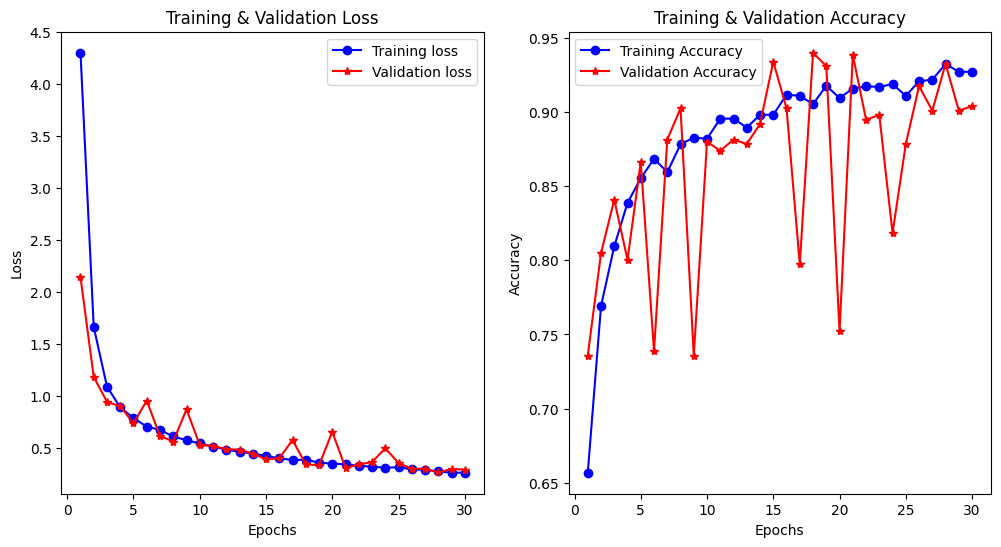

In [ ]:
import matplotlib.pyplot as plt

history_dict = history.history

train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(train_loss) + 1)

# График потерь
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'r*-', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# График точности
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r*-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.show()


In [ ]:
from google.colab import files
files.download("bert_sentence_model_vanilla.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Pooling

In [ ]:
import keras_tuner as kt

def build_model(hp):
    text_input = Input(shape=(384,), name='text_input')
    activation_choice = hp.Choice('activation', ['relu', 'swish', 'leaky_relu'])

    if activation_choice == 'leaky_relu':
        activation = tf.keras.layers.LeakyReLU(alpha=0.1)
    else:
        activation = activation_choice

    x_text = Dense(hp.Int('dense_units', 16, 128, 16), activation=activation)(text_input)
    x_text = Reshape((x_text.shape[-1], 1))(x_text)

    num_pool_layers = hp.Int('num_pool_layers_text', 1, 5)
    for _ in range(num_pool_layers):
        x_text = GlobalAveragePooling1D()(x_text)

    num_input = Input(shape=(4,), name='num_input')
    x_num = Dense(32, activation=activation)(num_input)
    x_num = Reshape((x_num.shape[-1], 1))(x_num)

    num_pool_layers_num = hp.Int('num_pool_layers_num', 1, 5)
    for _ in range(num_pool_layers_num):
        x_num = GlobalAveragePooling1D()(x_num)

    combined = Concatenate()([x_text, x_num])
    x = combined

    for i in range(hp.Int('num_layers', 1, 10)):
        reg_type = hp.Choice(f'reg_type_{i}', ['l1', 'l2', 'l1_l2'])
        reg_value = hp.Float(f'reg_value_{i}', 0.001, 0.1, 0.001)

        if reg_type == 'l1':
            reg = regularizers.l1(reg_value)
        elif reg_type == 'l2':
            reg = regularizers.l2(reg_value)
        else:
            reg = regularizers.l1_l2(l1=reg_value, l2=reg_value)

        x = Dense(hp.Int(f'units_{i}', 64, 256, 64), activation=activation, kernel_regularizer=reg)(x)
        x = Dropout(hp.Float(f'dropout_{i}', 0.1, 0.5, 0.1))(x)

    output = Dense(2, activation='softmax')(x)

    optimizer_choice = hp.Choice('optimizer', ['adam', 'adamw', 'nadam', 'rmsprop', 'sgd', 'adadelta', 'adagrad'])
    if optimizer_choice == 'adam':
        optimizer = Adam()
    elif optimizer_choice == 'adamw':
        optimizer = AdamW()
    elif optimizer_choice == 'nadam':
        optimizer = Nadam()
    elif optimizer_choice == 'rmsprop':
        optimizer = RMSprop()
    elif optimizer_choice == 'adadelta':
        optimizer = Adadelta()
    elif optimizer_choice == 'adagrad':
        optimizer = Adagrad()
    else:
        optimizer = SGD()

    model = Model(inputs=[text_input, num_input], outputs=output)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Настройка гиперпараметров
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='my_tuner_dir',
    project_name='text_num_classification'
)

# Поиск лучших гиперпараметров
tuner.search(
    [X_train_text, X_train_num], y_train,
    validation_data=([X_test_text, X_test_num], y_test),
    epochs=10,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

# Получение наилучшей модели
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

# Обучение лучшей модели
history = best_model.fit(
    [X_train_text, X_train_num], y_train,
    validation_data=([X_test_text, X_test_num], y_test),
    epochs=30,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

# Оценка модели на тестовой выборке
test_loss, test_acc = best_model.evaluate([X_test_text, X_test_num], y_test)
print(f"Тестовая точность: {test_acc:.4f}")

# Сохранение обученной модели
best_model.save("bert_sentence_model_pooling.h5")

Reloading Tuner from my_tuner_dir/text_num_classification/tuner0.json
Epoch 1/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.5471 - loss: 0.9002 - val_accuracy: 0.7327 - val_loss: 0.7025
Epoch 2/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7166 - loss: 0.6605 - val_accuracy: 0.7598 - val_loss: 0.5679
Epoch 3/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7698 - loss: 0.5449 - val_accuracy: 0.7868 - val_loss: 0.5183
Epoch 4/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7847 - loss: 0.5123 - val_accuracy: 0.7868 - val_loss: 0.4830
Epoch 5/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7893 - loss: 0.4868 - val_accuracy: 0.8033 - val_loss: 0.4749
Epoch 6/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8039 - loss: 0.4646 - val_accuracy: 0.8168 - val_loss: 0.4458
Epoch 7/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8041 - loss: 0.4466 - val_accuracy: 0.8138 - val_loss: 0.4514
Epoch 8/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/

Тестовая точность: 0.8964


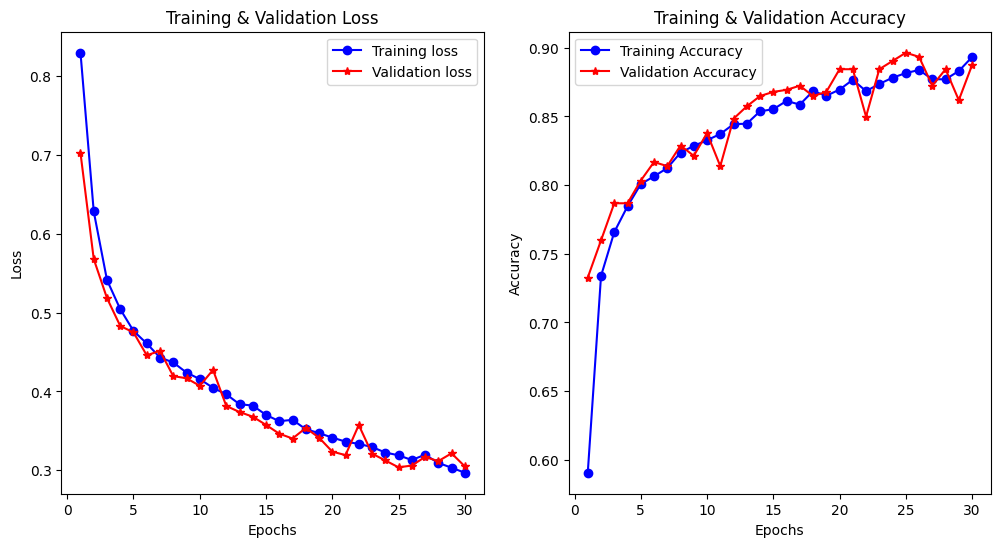

In [ ]:
import matplotlib.pyplot as plt

history_dict = history.history

train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(train_loss) + 1)

# График потерь
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'r*-', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# График точности
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r*-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.show()


In [ ]:
from google.colab import files
files.download("bert_sentence_model_pooling.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### LSTM

In [ ]:
import keras_tuner as kt

def build_model(hp):
    text_input = Input(shape=(384,), name='text_input')
    activation_choice = hp.Choice('activation', ['relu', 'swish', 'leaky_relu'])

    if activation_choice == 'leaky_relu':
        activation = tf.keras.layers.LeakyReLU(alpha=0.1)
    else:
        activation = activation_choice

    x_text = Dense(hp.Int('dense_units', 16, 128, 16), activation=activation)(text_input)
    x_text = Reshape((x_text.shape[-1], 1))(x_text)

    num_lstm_layers = hp.Int('num_lstm_layers', 1, 5)
    lstm_units = hp.Int('lstm_units', 32, 256, 32)

    for i in range(num_lstm_layers):
        return_sequences = i < num_lstm_layers - 1
        x_text = LSTM(lstm_units, return_sequences=return_sequences)(x_text)

    num_input = Input(shape=(4,), name='num_input')
    x_num = Dense(32, activation=activation)(num_input)
    x_num = Reshape((x_num.shape[-1], 1))(x_num)
    x_num = GlobalAveragePooling1D()(x_num)

    combined = Concatenate()([x_text, x_num])
    x = combined

    for i in range(hp.Int('num_layers', 1, 10)):
        reg_type = hp.Choice(f'reg_type_{i}', ['l1', 'l2', 'l1_l2'])
        reg_value = hp.Float(f'reg_value_{i}', 0.001, 0.1, 0.001)

        if reg_type == 'l1':
            reg = regularizers.l1(reg_value)
        elif reg_type == 'l2':
            reg = regularizers.l2(reg_value)
        else:
            reg = regularizers.l1_l2(l1=reg_value, l2=reg_value)

        x = Dense(hp.Int(f'units_{i}', 64, 256, 64), activation=activation, kernel_regularizer=reg)(x)
        x = Dropout(hp.Float(f'dropout_{i}', 0.1, 0.5, 0.1))(x)

    output = Dense(2, activation='softmax')(x)

    optimizer_choice = hp.Choice('optimizer', ['adam', 'adamw', 'rmsprop', 'sgd', 'adadelta', 'adagrad', 'nadam'])
    if optimizer_choice == 'adam':
        optimizer = Adam()
    elif optimizer_choice == 'adamw':
        optimizer = AdamW()
    elif optimizer_choice == 'rmsprop':
        optimizer = RMSprop()
    elif optimizer_choice == 'adadelta':
        optimizer = Adadelta()
    elif optimizer_choice == 'adagrad':
        optimizer = Adagrad()
    elif optimizer_choice == 'nadam':
        optimizer = Nadam()
    else:
        optimizer = SGD()

    model = Model(inputs=[text_input, num_input], outputs=output)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Настройка гиперпараметров
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='my_tuner_dir',
    project_name='text_num_classification'
)

# Поиск лучших гиперпараметров
tuner.search(
    [X_train_text, X_train_num], y_train,
    validation_data=([X_test_text, X_test_num], y_test),
    epochs=10,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

# Получение наилучшей модели
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

# Обучение лучшей модели
history = best_model.fit(
    [X_train_text, X_train_num], y_train,
    validation_data=([X_test_text, X_test_num], y_test),
    epochs=30,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

# Оценка модели на тестовой выборке
test_loss, test_acc = best_model.evaluate([X_test_text, X_test_num], y_test)
print(f"Тестовая точность: {test_acc:.4f}")

# Сохранение обученной модели
best_model.save("bert_sentence_model_lstm.h5")


Reloading Tuner from my_tuner_dir/text_num_classification/tuner0.json
Epoch 1/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.5152 - loss: 2.7732 - val_accuracy: 0.7628 - val_loss: 1.0895
Epoch 2/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.7766 - loss: 0.9032 - val_accuracy: 0.8378 - val_loss: 0.5321
Epoch 3/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.8278 - loss: 0.4900 - val_accuracy: 0.8559 - val_loss: 0.4064
Epoch 4/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.8549 - loss: 0.3881 - val_accuracy: 0.8318 - val_loss: 0.4438
Epoch 5/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8792 - loss: 0.3542 - val_accuracy: 0.8348 - val_loss: 0.4284
Epoch 6/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8613 - loss: 0.3690 - val_accuracy: 0.8889 - val_loss: 0.3245
Epoch 7/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.8889 - loss: 0.3315 - val_accuracy: 0.8739 - val_loss: 0.3203
Epoch 8/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 

Тестовая точность: 0.9219


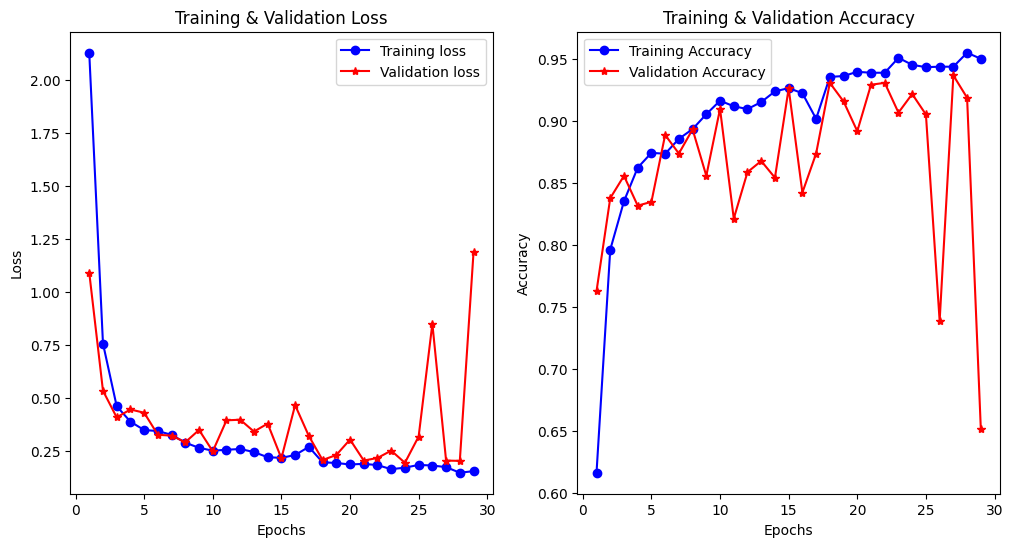

In [ ]:
import matplotlib.pyplot as plt

history_dict = history.history

train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(train_loss) + 1)

# График потерь
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'r*-', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# График точности
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r*-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.show()


In [ ]:
from google.colab import files
files.download("bert_sentence_model_lstm.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### GRU

In [ ]:
import keras_tuner as kt

def build_model(hp):
    text_input = Input(shape=(384,), name='text_input')
    activation_choice = hp.Choice('activation', ['relu', 'swish', 'leaky_relu'])

    if activation_choice == 'leaky_relu':
        activation = tf.keras.layers.LeakyReLU(alpha=0.1)
    else:
        activation = activation_choice

    x_text = Dense(hp.Int('dense_units', 16, 128, 16), activation=activation)(text_input)
    x_text = Reshape((x_text.shape[-1], 1))(x_text)

    num_gru_layers = hp.Int('num_gru_layers', 1, 5)
    gru_units = hp.Int('gru_units', 32, 256, 32)

    for i in range(num_gru_layers):
        return_sequences = i < num_gru_layers - 1
        x_text = GRU(gru_units, return_sequences=return_sequences)(x_text)

    num_input = Input(shape=(4,), name='num_input')
    x_num = Dense(32, activation=activation)(num_input)
    x_num = Reshape((x_num.shape[-1], 1))(x_num)
    x_num = GlobalAveragePooling1D()(x_num)

    combined = Concatenate()([x_text, x_num])
    x = combined

    for i in range(hp.Int('num_layers', 1, 10)):
        reg_type = hp.Choice(f'reg_type_{i}', ['l1', 'l2', 'l1_l2'])
        reg_value = hp.Float(f'reg_value_{i}', 0.001, 0.1, 0.001)

        if reg_type == 'l1':
            reg = regularizers.l1(reg_value)
        elif reg_type == 'l2':
            reg = regularizers.l2(reg_value)
        else:
            reg = regularizers.l1_l2(l1=reg_value, l2=reg_value)

        x = Dense(hp.Int(f'units_{i}', 64, 256, 64), activation=activation, kernel_regularizer=reg)(x)
        x = Dropout(hp.Float(f'dropout_{i}', 0.1, 0.5, 0.1))(x)

    output = Dense(2, activation='softmax')(x)

    optimizer_choice = hp.Choice('optimizer', ['adam', 'adamw', 'rmsprop', 'sgd', 'adadelta', 'adagrad', 'nadam'])
    if optimizer_choice == 'adam':
        optimizer = Adam()
    elif optimizer_choice == 'adamw':
        optimizer = AdamW()
    elif optimizer_choice == 'rmsprop':
        optimizer = RMSprop()
    elif optimizer_choice == 'adadelta':
        optimizer = Adadelta()
    elif optimizer_choice == 'adagrad':
        optimizer = Adagrad()
    elif optimizer_choice == 'nadam':
        optimizer = Nadam()
    else:
        optimizer = SGD()

    model = Model(inputs=[text_input, num_input], outputs=output)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Настройка гиперпараметров
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='my_tuner_dir',
    project_name='text_num_classification'
)

# Поиск лучших гиперпараметров
tuner.search(
    [X_train_text, X_train_num], y_train,
    validation_data=([X_test_text, X_test_num], y_test),
    epochs=10,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

# Получение наилучшей модели
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

# Обучение лучшей модели
history = best_model.fit(
    [X_train_text, X_train_num], y_train,
    validation_data=([X_test_text, X_test_num], y_test),
    epochs=30,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

# Оценка модели на тестовой выборке
test_loss, test_acc = best_model.evaluate([X_test_text, X_test_num], y_test)
print(f"Тестовая точность: {test_acc:.4f}")

# Сохранение обученной модели
best_model.save("bert_sentence_model_gru.h5")

Reloading Tuner from my_tuner_dir/text_num_classification/tuner0.json
Epoch 1/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.5529 - loss: 2.7728 - val_accuracy: 0.7462 - val_loss: 1.1170
Epoch 2/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.7731 - loss: 0.9083 - val_accuracy: 0.7898 - val_loss: 0.5706
Epoch 3/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.8259 - loss: 0.5081 - val_accuracy: 0.8153 - val_loss: 0.4743
Epoch 4/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.8572 - loss: 0.4072 - val_accuracy: 0.8619 - val_loss: 0.3622
Epoch 5/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.8683 - loss: 0.3742 - val_accuracy: 0.8589 - val_loss: 0.3666
Epoch 6/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.8739 - loss: 0.3535 - val_accuracy: 0.8934 - val_loss: 0.3242
Epoch 7/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9012 - loss: 0.3043 - val_accuracy: 0.8799 - val_loss: 0.3542
Epoch 8/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s

Тестовая точность: 0.9324


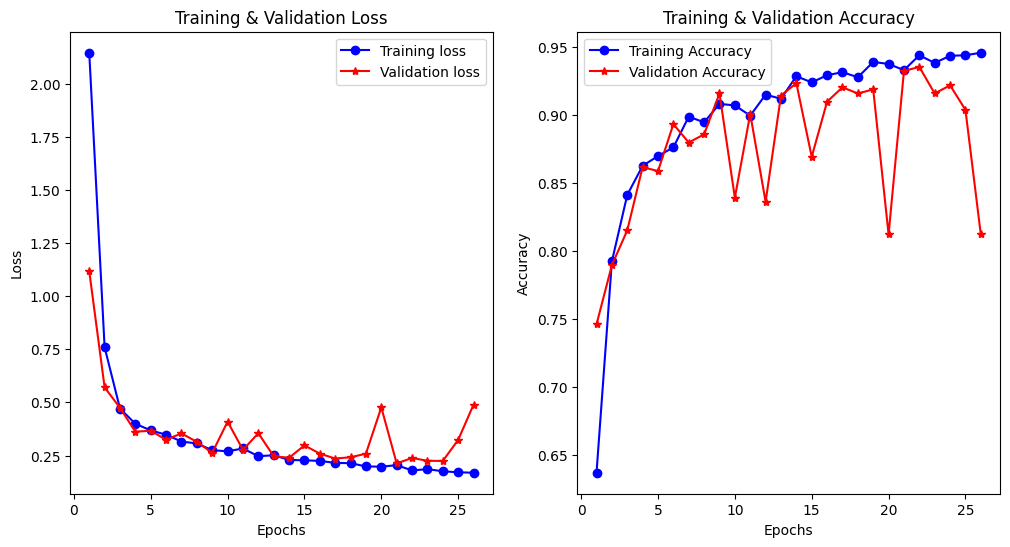

In [ ]:
import matplotlib.pyplot as plt

history_dict = history.history

train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(train_loss) + 1)

# График потерь
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'r*-', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# График точности
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r*-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.show()


In [ ]:
from google.colab import files
files.download("bert_sentence_model_gru.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>